In [57]:
import netCDF4 as nc
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
#import zipfile
import numpy as np
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors


In [58]:
# Paths
ddbnetcdf_path = '/home/fuaday/scratch/ncrb-models/MESH-ncrb/MESH_drainage_database.nc'
climatedata_path = '/home/fuaday/scratch/ncrb-models/easymore-outputs-merged/clf_ysm2.nc'
ncrbshapefile_path = '/scratch/fuaday/ncrb-models/geofabric-outputs/ncrb-geofabric/ncrb_subbasins.shp'
ncrb_rivshapefile_path = '/scratch/fuaday/ncrb-models/geofabric-outputs/ncrb-geofabric/ncrb_rivers.shp'
#zip_path = '/project/6008034/Climate_Forcing_Data/geospatial-data/HydroLakes/HydroLAKES_polys_v10_shp.zip'
lake_shapefile_path = '/scratch/fuaday/ncrb-models/geofabric-outputs/ncrb-geofabric/HydrolakesV10/HydroLAKES_polys_v10_shp/HydroLAKES_polys_ncrb.shp'


In [59]:
#ncrb_lakes = gpd.read_file(lake_shapefile_path).to_crs(epsg=4326)
ncrb_gdf = gpd.read_file(ncrbshapefile_path).to_crs(epsg=4326)
#ncrb_riv_gdf = gpd.read_file(ncrb_rivshapefile_path).to_crs(epsg=4326)

# Load NetCDF data using a context manager to handle file closing
with nc.Dataset(ddbnetcdf_path) as dataset:
    # Extract variables directly into a DataFrame
    df = pd.DataFrame({
        'subbasin': dataset.variables['subbasin'][:].astype(int),
        'chnlslope': dataset.variables['ChnlSlope'][:],
        'chnllength': dataset.variables['ChnlLength'][:],
        'drainagearea': dataset.variables['DA'][:],
        'riverorder': dataset.variables['IAK'][:],
        'iwfflag': dataset.variables['IWF'][:]
    })

    # Extract land use classes and append as separate columns
    landuse_classes = dataset.variables['LandUse'][:]
    gru_class = dataset.variables['GRU'][:]
    for i, landuse in enumerate(landuse_classes):
        df[landuse] = gru_class[:, i]

# Load and prepare shapefile
gdf = gpd.read_file(ncrbshapefile_path).to_crs(epsg=4326)
gdf['COMID'] = gdf['COMID'].astype(int)

# Merge DataFrame with GeoDataFrame based on 'subbasin'
merged_gdf = gdf.merge(df, left_on='COMID', right_on='subbasin', how='left')

In [60]:
cdataset = nc.Dataset(climatedata_path)
fufu1 = cdataset.variables['COMID'][:]
fufu2 = cdataset.variables['RDRS_v2.1_A_PR0_SFC'][:]
cdataset.close()

if fufu2.ndim > 1:
    fufu2 = fufu2.ravel()

# Create a DataFrame using data from the NetCDF file
dfc = pd.DataFrame({
    'CCOMID': np.array(fufu1, dtype=np.int32),  # Convert COMID to integer type
    'precann': np.array(fufu2*3600, dtype=np.float32)  # Ensure RDRS_v2.1_A_PR0_SFC remains float32
})

merged_gdf2 = merged_gdf.merge(dfc, left_on='COMID', right_on='CCOMID', how='left')

In [61]:
merged_gdf2

,COMID,unitarea,hillslope,ncontr,geometry,subbasin,chnlslope,chnllength,drainagearea,riverorder,...,Sub-polar or polar barren-lichen-moss,Wetland,Cropland,Barren lands,Urban,Water,Snow and Ice,Dump,CCOMID,precann
0,71000022,29.205639,0,1,"POLYGON ((-101.78625 59.10708, -101.78375 59.1...",71000022,0.000219,12748.757507,0.022167,5,...,0.0,0.072714,0.000000,0.003756,0.000000,0.246185,0.0,0.0,71000022,513.956665
1,71000023,27.179038,0,1,"POLYGON ((-101.83792 59.11875, -101.83375 59.1...",71000023,0.000077,14248.005018,0.021885,5,...,0.0,0.071641,0.000000,0.005899,0.000000,0.354014,0.0,0.0,71000023,510.866394
2,71000024,7.862929,0,1,"POLYGON ((-101.91042 59.05458, -101.90792 59.0...",71000024,0.000175,5126.908244,0.021830,5,...,0.0,0.042398,0.000000,0.010178,0.000000,0.238771,0.0,0.0,71000024,506.933441
3,71000025,53.969083,0,1,"POLYGON ((-101.98125 59.01292, -101.97708 59.0...",71000025,0.000394,17202.803507,0.019589,5,...,0.0,0.043782,0.000000,0.005579,0.000000,0.320734,0.0,0.0,71000025,505.552612
4,71000026,28.626667,0,1,"POLYGON ((-101.92208 59.09042, -101.91958 59.0...",71000026,0.000727,3977.312558,0.002232,3,...,0.0,0.057537,0.000000,0.011393,0.000000,0.258352,0.0,0.0,71000026,506.517151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32271,71048949,76.116685,0,2,"MULTIPOLYGON (((-97.83125 46.00875, -97.82542 ...",71048949,0.000171,9357.690399,0.000076,1,...,0.0,0.097597,0.809535,0.000563,0.034164,0.003748,0.0,0.0,71048949,606.756042
32272,71048950,43.278839,0,2,"POLYGON ((-96.07708 46.00542, -96.07625 46.005...",71048950,0.001511,12016.268274,0.000043,1,...,0.0,0.063817,0.890736,0.000000,0.034442,0.001164,0.0,0.0,71048950,719.804138
32273,71048951,69.279829,0,2,"MULTIPOLYGON (((-96.65292 45.93542, -96.65208 ...",71048951,0.000845,16905.508589,0.000069,1,...,0.0,0.012734,0.943788,0.000000,0.035741,0.000221,0.0,0.0,71048951,652.792297
32274,71050686,10.810153,1,2,"POLYGON ((-108.54708 52.72625, -108.54625 52.7...",71050686,0.000100,1000.000000,0.000001,1,...,0.0,0.002581,0.634842,0.000416,0.031005,0.076844,0.0,0.0,71050686,356.552460


In [62]:
# Check the result
# print(merged_gdf.head())
# Save the merged GeoDataFrame as a new shapefile
output_path = '/scratch/fuaday/ncrb-models/geofabric-outputs/ncrb_shapefile_drainagedatabase.shp'
merged_gdf2.to_file(output_path)

/tmp/ipykernel_10422/3786547552.py:5: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  merged_gdf2.to_file(output_path)


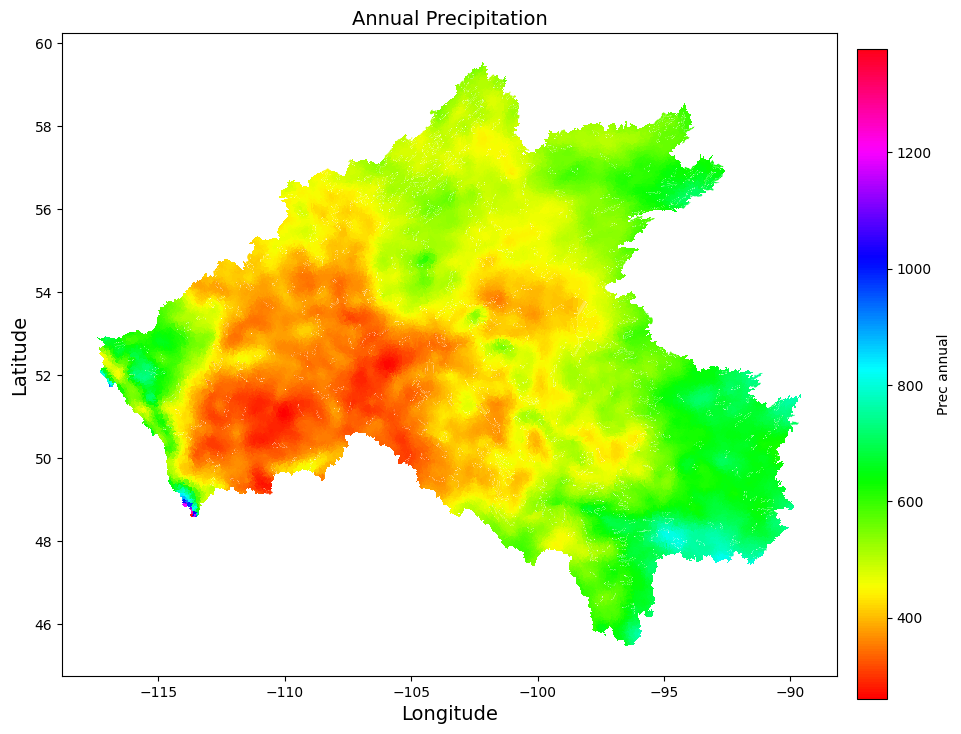

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# Plot Drainage area
viridis_r = plt.cm.get_cmap('hsv')#.reversed()
prec_mapping = merged_gdf2.plot(column='precann', ax=ax, legend=False, vmin=merged_gdf2['precann'].min(), vmax=merged_gdf2['precann'].max(), cmap=viridis_r)
# Manually add colorbar axes with reduced height
cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.65])  # Reduced height
colorbar = fig.colorbar(prec_mapping.get_children()[0], cax=cbar_ax, orientation='vertical')
colorbar.set_label('Prec annual')
# Add axis labels and plot title
ax.set_xlabel('Longitude', fontsize=14)  # Assuming appropriate labels for geographic data
ax.set_ylabel('Latitude', fontsize=14)
ax.set_title('Annual Precipitation', fontsize=14)
# Save the figure
plt.savefig('AnnualPrecipitation.png', dpi=300)  # Adjust dpi for higher resolution
plt.show()

In [ ]:
# Assume merged_gdf is already prepared and loaded as per your previous code
# Identify the last 16 columns and ignore the last one
gru_columns = merged_gdf.columns[-16:-1]  # Excludes the very last column

# Pre-calculate the percentage values
percentages = [(merged_gdf[col].sum() / len(merged_gdf) * 100) for col in gru_columns]
rounded_percentages = [round(p, 3) for p in percentages]

# Create a modified jet colormap that sets zero values to white
cmap = plt.cm.gnuplot2_r
cmap.set_under('white', alpha=0)
#cmap = plt.cm.jet
#cmap.set_under('white', alpha=0)

# Set up the figure and axes for a 3x5 grid (15 plots)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 9), sharex=True, sharey=True)

# Create an Image for colormap scaling
sm = plt.cm.ScalarMappable(cmap=cmap, norm=mcolors.Normalize(vmin=0.02, vmax=1))
sm._A = []  # Fake up the array of the scalar mappable. Urgh...

# Loop through and plot each column
for i, (col, rounded_percentage) in enumerate(zip(gru_columns, rounded_percentages)):
    ax = axes.flatten()[i]
    merged_gdf.plot(column=col, ax=ax, cmap=cmap, vmin=0.01, vmax=1)
    ax.set_title(col, fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])

    # Display the pre-calculated percentage with a percentage sign in the top left corner of the subplot
    ax.text(0.05, 0.95, f"{rounded_percentage}%", transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="none", alpha=0.5))

# Hide any unused subplots
for i in range(len(gru_columns), axes.flatten().shape[0]):
    axes.flatten()[i].set_visible(False)

# Adjust layout
fig.tight_layout(pad=1.0)
fig.subplots_adjust(right=0.85, hspace=0.1, wspace=0.1)

# Place colorbar
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])
fig.colorbar(sm, cax=cbar_ax)

# Save the figure if needed
plt.savefig('landuse_gru_plots.png')

# Show the plot
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# Plot Drainage area
viridis_r = plt.cm.get_cmap('gnuplot2').reversed()
slope_mapping = merged_gdf.plot(column='drainagearea', ax=ax, legend=False, vmin=merged_gdf['drainagearea'].min(), vmax=merged_gdf['drainagearea'].max(), cmap=viridis_r)
# Manually add colorbar axes with reduced height
cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.65])  # Reduced height
colorbar = fig.colorbar(slope_mapping.get_children()[0], cax=cbar_ax, orientation='vertical')
colorbar.set_label('Slope Value')
# Add axis labels and plot title
ax.set_xlabel('Longitude', fontsize=14)  # Assuming appropriate labels for geographic data
ax.set_ylabel('Latitude', fontsize=14)
ax.set_title('Channel Slope and Lake Distribution', fontsize=14)
# Save the figure
#plt.savefig('Channel_Slope_and_Lakes.png', dpi=300)  # Adjust dpi for higher resolution
plt.show()

In [ ]:
# Modify 'chnlslope' Values
#gdf['chnlslope'] = gdf['chnlslope'].apply(lambda x: 0 if x > 0.025 else x)
# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# Plot channel slope
viridis_r = plt.cm.get_cmap('gnuplot2').reversed()
slope_mapping = merged_gdf.plot(column='chnlslope', ax=ax, legend=False, vmin=merged_gdf['chnlslope'].min(), vmax=merged_gdf['chnlslope'].max(), cmap=viridis_r)
# Plot lakes
lake_mapping = ncrb_lakes.plot(ax=ax, color='#0066FF', alpha=1)
# Manually add colorbar axes with reduced height
cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.65])  # Reduced height
colorbar = fig.colorbar(slope_mapping.get_children()[0], cax=cbar_ax, orientation='vertical')
colorbar.set_label('Slope Value')
# Add axis labels and plot title
ax.set_xlabel('Longitude', fontsize=14)  # Assuming appropriate labels for geographic data
ax.set_ylabel('Latitude', fontsize=14)
ax.set_title('Channel Slope and Lake Distribution', fontsize=14)
# Save the figure
plt.savefig('Channel_Slope_and_Lakes.png', dpi=300)  # Adjust dpi for higher resolution
plt.show()

In [ ]:
!pip install contextily

In [ ]:
import contextily as ctx
# Load the subbasins, rivers, and lakes shapefiles
ncrb_subbasins_path = '/scratch/fuaday/J_Core_modeling/Nelson_project/Input_data_NCRB/Input_data_NCRB/NCRB_shapefiles/NCRB_Subbasins.shp'
ncrb_rivers_path = '/scratch/fuaday/J_Core_modeling/Nelson_project/Input_data_NCRB/Input_data_NCRB/NCRB_shapefiles/NCRB_River_75.shp'
ncrb_lakes_path = '/scratch/fuaday/ncrb-models/geofabric-outputs/ncrb-geofabric/HydrolakesV10/HydroLAKES_polys_v10_shp/HydroLAKES_polys_ncrb.shp'
ncrb_subbasins = gpd.read_file(ncrb_subbasins_path)
ncrb_rivers = gpd.read_file(ncrb_rivers_path)
ncrb_lakes = gpd.read_file(ncrb_lakes_path)
# Ensure all data is in the same CRS, here using EPSG:3857
ncrb_subbasins = ncrb_subbasins.to_crs(epsg=3857)
ncrb_rivers = ncrb_rivers.to_crs(epsg=3857)
ncrb_lakes = ncrb_lakes.to_crs(epsg=3857)
# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
# Plot subbasins colored by 'MAJ_BAS'
ncrb_subbasins.plot(ax=ax, column='MAJ_BAS', legend=True, cmap='viridis', alpha=0.9)
# Plot rivers in a lighter blue with increased transparency
ncrb_rivers.plot(ax=ax, color='#00B0F0', linewidth=1, alpha=0.9)
# Plot lakes in a lighter '#0066FF' with increased transparency
ncrb_lakes.plot(ax=ax, color='#00B0F0', alpha=0.9)
# Add a basemap
ctx.add_basemap(ax, crs=ncrb_subbasins.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
# Optional: Adjust the legend
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.15, 0.5))
leg.set_title('Major Basin', prop={'size': 12})
# Adding labels and titles
ax.set_title('NCRB Subbasins, Rivers, and Lakes', fontsize=16)
ax.axis('off')  # Turn off the axis for a cleaner look
# Save the figure
plt.savefig('NCRB_Subbasins_Rivers_Lakes.png', dpi=300)  # Adjust dpi as needed for quality
plt.show()